In [1]:
import numpy as np
import pytpc
from pytpc.fitting.mcopt_wrapper import Minimizer
from pytpc.constants import *
import pytpc.simulation
import pytpc.tpcplot
import pytpc.vmedata
import pandas as pd
import matplotlib.pyplot as plt
import scipy.signal
import h5py
from scipy.interpolate import UnivariateSpline, interp1d
from scipy.optimize import differential_evolution, minimize, basinhopping, leastsq
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import LogNorm
import os
#import cmaps
import yaml
import scipy
from copy import copy, deepcopy
from pytpc.utilities import find_exclusion_region, read_lookup_table
import math
from effsim.paramgen import uniform_param_generator
from effsim.effsim import EventSimulator
from math import pi
import time
import matplotlib.pyplot as plt

/home/chen/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [11]:
with open('/home/chen/Real Data/config_e15503a_runs_92-104.yml', 'r') as f:
    config = yaml.load(f)

mcfitter = pytpc.fitting.MCFitter(config)
num_iters = config['num_iters']
num_pts = config['num_pts']
red_factor = config['red_factor']

full = h5py.File('/home/chen/Real Data/clean_run_0102.h5', 'r')
good_event = [689, 765, 896, 305, 504, 575, 456, 299, 399, 156, 231, 7832, 1568, 1354, 789, 485, 2456, 357, 4568, 1448, 3578, 745, 430, 1676, 811, 641, 871, 785]
print(len(good_event))

28


**Monte Carlo**

Monte Carlo event 689 with noise: 1.2699918746948242 seconds
position chi2: 95.24211388813151 energy chi2: 6.015682428527129 vertex chi^2: 0.1497575777517078 total chi2: 101.40755389441036
Monte Carlo event 689 without noise: 0.00518035888671875 seconds
position chi2: 22.16476735678083 energy chi2: 8.098767361105038 vertex chi^2: 3.465576557953559 total chi2: 33.72911127583943
Monte Carlo event 765 with noise: 0.846980094909668 seconds
position chi2: 88.76753703609462 energy chi2: 11.109979294432414 vertex chi^2: 0.12968999498115114 total chi2: 100.00720632550819
Monte Carlo event 765 without noise: 0.004534244537353516 seconds
position chi2: 14.147255710322943 energy chi2: 14.918276387836082 vertex chi^2: 4.177770398519018 total chi2: 33.24330249667804
Monte Carlo event 896 with noise: 1.5417325496673584 seconds
position chi2: 96.30039239034559 energy chi2: 3.9175054670703426 vertex chi^2: 0.010110642318214028 total chi2: 100.22800849973414
Monte Carlo event 896 without noise: 0.00423

Monte Carlo event 745 without noise: 0.004320383071899414 seconds
position chi2: 34.74575706699384 energy chi2: 1.9886949548723165 vertex chi^2: 0.021876762734338345 total chi2: 36.75632878460049
Monte Carlo event 430 with noise: 1.340733528137207 seconds
position chi2: 93.25893474943396 energy chi2: 5.573247596659604 vertex chi^2: 0.15616569274786563 total chi2: 98.98834803884142
Monte Carlo event 430 without noise: 0.004803180694580078 seconds
position chi2: 23.201162523285884 energy chi2: 6.311649338015962 vertex chi^2: 7.478764653905985 total chi2: 36.99157651520783
Monte Carlo event 1676 with noise: 3.0272109508514404 seconds
position chi2: 90.67146662004436 energy chi2: 4.384354605580987 vertex chi^2: 0.3244799420189177 total chi2: 95.38030116764425
Monte Carlo event 1676 without noise: 0.004214763641357422 seconds
position chi2: 44.45463946193291 energy chi2: 6.712259904892885 vertex chi^2: 0.01431892573601365 total chi2: 51.18121829256181
Monte Carlo event 811 with noise: 0.849

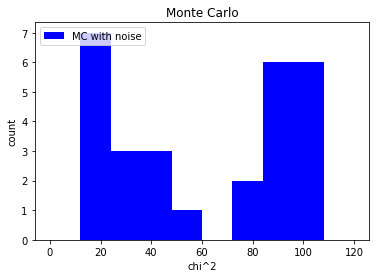

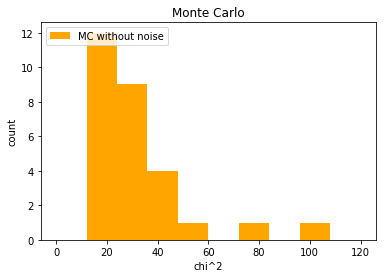

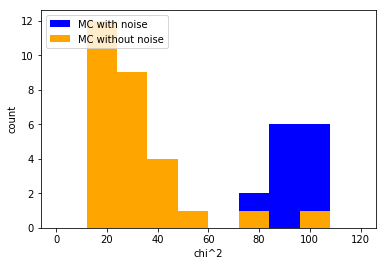

In [7]:
mc_chi2_with_noise = []
mc_chi2_without_noise = []
time_list = []

for i in range(len(good_event)):
    evt_ID = good_event[i]
    dataset_name = '/clean'
    evt_full = full[dataset_name]
    xyzs_h5 = evt_full[str(evt_ID)]

    xyzs = np.array(xyzs_h5)

    #delete the points which are farther away from the center of the spiral
    del_list = []

    for i in range(len(xyzs)):
        if (xyzs[i,6]) > 150.0:
            del_list.append(i)
    cut_xyzs = np.delete(xyzs,del_list,axis=0)
    
    xy = xyzs[:, 0:2]
    xy_C = np.ascontiguousarray(xy, dtype=np.double)
    cx, cy = pytpc.cleaning.hough_circle(xy_C)

    cut_xy = cut_xyzs[:, 0:2]
    cut_xy_C = np.ascontiguousarray(cut_xy, dtype=np.double)
    cut_cx, cut_cy = pytpc.cleaning.hough_circle(cut_xy_C)
    
    t0 = time.time()
    uvw, (cu, cv) = mcfitter.preprocess(xyzs[:,0:5], center=(cx, cy), rotate_pads=False) # get calibrated set of data
    uvw_values = uvw.values #transform pd file to arrays
    mcres, minChis, all_params, good_param_idx = mcfitter.process_event(uvw, cu, cv, return_details=True)
    t1 = time.time()
    if np.isnan(mcres['posChi2']) != True:
        mc_chi2_with_noise.append(mcres['posChi2']+mcres['enChi2']+mcres['vertChi2'])
    time_list.append(t1-t0)
    print("Monte Carlo event "+str(evt_ID)+" with noise: "+str(t1-t0)+' seconds')
    print("position chi2: "+str(mcres['posChi2'])+' energy chi2: '+str(mcres['enChi2'])+' vertex chi^2: '+str(mcres['vertChi2'])+' total chi2: '+str(mcres['posChi2']+mcres['enChi2']+mcres['vertChi2']))
    
    t2 = time.time()
    cut_uvw, (cut_cu, cut_cv) = mcfitter.preprocess(cut_xyzs[:,0:5], center=(cut_cx, cut_cy), rotate_pads=False) # get calibrated set of data
    cut_uvw_values = cut_uvw.values #transform pd file to arrays
    t3 = time.time()
    cut_mcres, cut_minChis, cut_all_params, cut_good_param_idx = mcfitter.process_event(cut_uvw, cut_cu, cut_cv, return_details=True)
    if np.isnan(cut_mcres['posChi2']) != True:
        mc_chi2_without_noise.append(cut_mcres['posChi2']+cut_mcres['enChi2']+cut_mcres['vertChi2'])
    time_list.append(t3-t2)
    print("Monte Carlo event "+str(evt_ID)+" without noise: "+str(t3-t2)+' seconds')
    print("position chi2: "+str(cut_mcres['posChi2'])+' energy chi2: '+str(cut_mcres['enChi2'])+' vertex chi^2: '+str(cut_mcres['vertChi2'])+' total chi2: '+str(cut_mcres['posChi2']+cut_mcres['enChi2']+cut_mcres['vertChi2']))
    
#print(chi2_with_noise)
#print(chi2_without_noise)
print("average time: "+str(sum(time_list) / float(len(time_list)))+" seconds")
print('average chi2 value (with noise): '+ str(sum(mc_chi2_with_noise) / float(len(mc_chi2_with_noise))))
print('average chi2 value (without noise): '+ str(sum(mc_chi2_without_noise) / float(len(mc_chi2_without_noise))))

plt.hist(mc_chi2_with_noise, label='MC with noise', bins=10, color='blue',range=(0,120))
plt.title('Monte Carlo')
plt.legend(loc=2)
plt.xlabel('chi^2')
plt.ylabel('count')
plt.show()

plt.hist(mc_chi2_without_noise, label='MC without noise', bins=10, color='orange',range=(0,120))
plt.title('Monte Carlo')
plt.legend(loc=2)
plt.xlabel('chi^2')
plt.ylabel('count')
plt.show()

plt.hist(mc_chi2_with_noise, label='MC with noise', bins=10, color='blue',range=(0,120))
plt.hist(mc_chi2_without_noise, label='MC without noise', bins=10, color='orange',range=(0,120))
plt.xlabel('chi^2')
plt.ylabel('count')
plt.legend(loc=2)
plt.show()

**Differential Evolution**

Differential Evolution event 689 with noise: 20.70845937728882 seconds
chi2 value: 74.92659721973207
Differential Evolution event 689 without noise: 30.944457292556763 seconds
chi2 value: 33.65341977854242
Differential Evolution event 765 with noise: 24.818307161331177 seconds
chi2 value: 35.323939178719826
Differential Evolution event 765 without noise: 24.802055597305298 seconds
chi2 value: 78.81640979534909
Differential Evolution event 896 with noise: 20.198147535324097 seconds
chi2 value: 15.549969486416138
Differential Evolution event 896 without noise: 38.37148952484131 seconds
chi2 value: 14.470858649940844
Differential Evolution event 305 with noise: 36.49518632888794 seconds
chi2 value: 14.119464090572261
Differential Evolution event 305 without noise: 35.22419238090515 seconds
chi2 value: 14.141416215291494
Differential Evolution event 504 with noise: 23.10353660583496 seconds
chi2 value: 68.04043627321876
Differential Evolution event 504 without noise: 21.112534284591675 sec

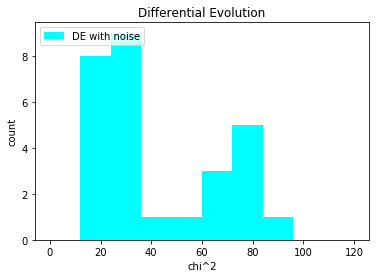

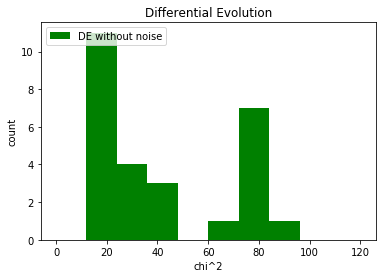

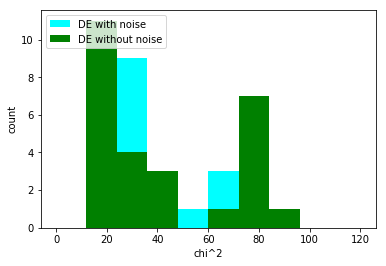

In [8]:
de_chi2_with_noise = []
de_chi2_without_noise = []
time_list = []


for i in range(len(good_event)):
    evt_ID = good_event[i]
    dataset_name = '/clean'
    evt_full = full[dataset_name]
    xyzs_h5 = evt_full[str(evt_ID)]

    xyzs = np.array(xyzs_h5)

    #delete the points which are farther away from the center of the spiral
    del_list = []

    for i in range(len(xyzs)):
        if (xyzs[i,6]) > 150.0:
            del_list.append(i)
    cut_xyzs = np.delete(xyzs,del_list,axis=0)
    
    xy = xyzs[:, 0:2]
    xy_C = np.ascontiguousarray(xy, dtype=np.double)
    cx, cy = pytpc.cleaning.hough_circle(xy_C)

    cut_xy = cut_xyzs[:, 0:2]
    cut_xy_C = np.ascontiguousarray(cut_xy, dtype=np.double)
    cut_cx, cut_cy = pytpc.cleaning.hough_circle(cut_xy_C)
    
    uvw, (cu, cv) = mcfitter.preprocess(xyzs[:,0:5], center=(cx, cy), rotate_pads=False)
    uvw_values = uvw.values
    uvw_sorted = uvw.sort_values(by='w', ascending=True)
    prefit_data = uvw_sorted.iloc[-len(uvw_sorted) // 4:].copy()
    prefit_res = mcfitter.linear_prefit(prefit_data, cu, cv)
    ctr0 = mcfitter.guess_parameters(prefit_res)
    exp_pos = uvw_sorted[['u', 'v', 'w']].values.copy() / 1000
    exp_hits = np.zeros(10240)
    for a, p in uvw[['a', 'pad']].values:
        exp_hits[int(p)] = a
        
    cut_uvw, (cut_cu, cut_cv) = mcfitter.preprocess(cut_xyzs[:,0:5], center=(cut_cx, cut_cy), rotate_pads=False) # get calibrated set of data
    cut_uvw_values = cut_uvw.values
    cut_uvw_sorted = cut_uvw.sort_values(by='w', ascending=True)
    cut_prefit_data = cut_uvw_sorted.iloc[-len(cut_uvw_sorted) // 4:].copy()
    cut_prefit_res = mcfitter.linear_prefit(cut_prefit_data, cut_cu, cut_cv)
    cut_ctr0 = mcfitter.guess_parameters(cut_prefit_res)
    cut_exp_pos = cut_uvw_sorted[['u', 'v', 'w']].values.copy() / 1000
    cut_exp_hits = np.zeros(10240)
    for a, p in cut_uvw[['a', 'pad']].values:
        cut_exp_hits[int(p)] = a
        
    minimizer = Minimizer(mcfitter.tracker, mcfitter.evtgen, num_iters, num_pts, red_factor)
    
    def f(y):
        ctr = np.zeros([1,6])
        ctr[0] = y
        chi_result = minimizer.run_tracks(ctr, exp_pos, exp_hits)
        return sum(chi_result[0])
    eps = np.sqrt(np.finfo(np.float).eps)
    def jacobian(x):
        return scipy.optimize.approx_fprime(x,f,eps)
    
    def cut_f(y):
        ctr = np.zeros([1,6])
        ctr[0] = y
        chi_result = minimizer.run_tracks(ctr, cut_exp_pos, cut_exp_hits)
        return sum(chi_result[0])
    eps = np.sqrt(np.finfo(np.float).eps)
    def cut_jacobian(x):
        return scipy.optimize.approx_fprime(x,cut_f,eps)
    
    i = 1
    def callbackF(x, convergence=10):
        global i
        print('{0:4d}{1: 3.6f}{2: 3.6f}{3: 3.6f}{4: 3.6f}{5: 3.6f}{6: 3.6f}{7: 3.6f}'.format(i,x[0],x[1],x[2],x[3],x[4],x[5],f(x)))
        i += 1
        
    j = 1
    def cut_callbackF(x, convergence=10):
        global j
        print('{0:4d}{1: 3.6f}{2: 3.6f}{3: 3.6f}{4: 3.6f}{5: 3.6f}{6: 3.6f}{7: 3.6f}'.format(j,x[0],x[1],x[2],x[3],x[4],x[5],cut_f(x)))
        j += 1
    
    bounds = [(-1,1), (-1, 1), (0, 1), (0,5), (-2 * pi, 2 * pi), (-2 * pi, 2 * pi)]
    
    t0 = time.time()
    results = scipy.optimize.differential_evolution(f, bounds, maxiter=1000, strategy='best1bin', recombination=0.7, popsize=15, mutation=(0.5,1.5))
    t1 = time.time()
    if np.isnan(results.fun) != True:
        de_chi2_with_noise.append(results.fun)
    time_list.append(t1-t0)
    print("Differential Evolution event "+str(evt_ID)+" with noise: "+str(t1-t0)+' seconds')
    print("chi2 value: "+str(results.fun))
    
    t2 = time.time()
    cut_results = scipy.optimize.differential_evolution(cut_f, bounds, maxiter=1000, strategy='best1bin',recombination=0.7, popsize=15, mutation=(0.5,1.5))
    t3 = time.time()
    if np.isnan(cut_results.fun) != True:
        de_chi2_without_noise.append(cut_results.fun)
    time_list.append(t3-t2)
    print("Differential Evolution event "+str(evt_ID)+" without noise: "+str(t3-t2)+' seconds')
    print("chi2 value: "+str(cut_results.fun))
    
print("average time: "+str(sum(time_list) / float(len(time_list)))+" seconds")
print('average chi2 value (with noise): '+ str(sum(de_chi2_with_noise) / float(len(de_chi2_with_noise))))
print('average chi2 value (without noise): '+ str(sum(de_chi2_without_noise) / float(len(de_chi2_without_noise))))

plt.hist(de_chi2_with_noise, label='DE with noise', bins=10, color='cyan',range=(0,120))
plt.title('Differential Evolution')
plt.legend(loc=2)
plt.xlabel('chi^2')
plt.ylabel('count')
plt.show()

plt.hist(de_chi2_without_noise, label='DE without noise', bins=10, color='green',range=(0,120))
plt.title('Differential Evolution')
plt.legend(loc=2)
plt.xlabel('chi^2')
plt.ylabel('count')
plt.show()

plt.hist(de_chi2_with_noise, label='DE with noise', bins=10, color='cyan',range=(0,120))
plt.hist(de_chi2_without_noise, label='DE without noise', bins=10, color='green',range=(0,120))
plt.xlabel('chi^2')
plt.ylabel('count')
plt.legend(loc=2)
plt.show()


**Basinhopping**

Basinhopping (with noise) event 689 with Nelder-Mead method: 3.3329339027404785 seconds
chi2 value: 49.59115116656121
Basinhopping (without noise) event 689 with Nelder-Mead method: 3.6012041568756104 seconds
chi2 value: 34.25202132255559
Basinhopping (with noise) event 689 with Powell method: 5.929903507232666 seconds
chi2 value: 82.22409672364108
Basinhopping (without noise) event 689 with Powell method: 5.4348955154418945 seconds
chi2 value: 35.57537074314218
Basinhopping (with noise) event 689 with CG method: 3.197985887527466 seconds
chi2 value: 104.6134629740158
Basinhopping (without noise) event 689 with CG method: 1.4144260883331299 seconds
chi2 value: 100.17071767943828
Basinhopping (with noise) event 689 with BFGS method: 15.023584842681885 seconds
chi2 value: 79.92852580330657
Basinhopping (without noise) event 689 with BFGS method: 4.470758676528931 seconds
chi2 value: 44.97679198936428
Basinhopping (with noise) event 689 with L-BFGS-B method: 2.982560873031616 seconds
chi2

Basinhopping (without noise) event 504 with L-BFGS-B method: 3.854764938354492 seconds
chi2 value: 67.9591882285381
Basinhopping (with noise) event 504 with TNC method: 1.7078819274902344 seconds
chi2 value: 96.9564131201732
Basinhopping (without noise) event 504 with TNC method: 1.6976923942565918 seconds
chi2 value: 85.80928611272553
Basinhopping (with noise) event 504 with COBYLA method: 2.1208314895629883 seconds
chi2 value: 88.7572202751722
Basinhopping (without noise) event 504 with COBYLA method: 1.2895395755767822 seconds
chi2 value: 69.64475831600646
Basinhopping (with noise) event 504 with SLSQP method: 3.3833565711975098 seconds
chi2 value: 81.46486321842734
Basinhopping (without noise) event 504 with SLSQP method: 0.9342241287231445 seconds
chi2 value: 44.54907531583796
Basinhopping (with noise) event 575 with Nelder-Mead method: 2.7189905643463135 seconds
chi2 value: 45.45755160567337
Basinhopping (without noise) event 575 with Nelder-Mead method: 2.4928643703460693 second

Basinhopping (with noise) event 156 with Powell method: 8.082656621932983 seconds
chi2 value: 64.13522707062067
Basinhopping (without noise) event 156 with Powell method: 11.332793474197388 seconds
chi2 value: 44.21230043132278
Basinhopping (with noise) event 156 with CG method: 6.596304655075073 seconds
chi2 value: 103.45247341858126
Basinhopping (without noise) event 156 with CG method: 5.251074314117432 seconds
chi2 value: 55.45867097448121
Basinhopping (with noise) event 156 with BFGS method: 8.195115089416504 seconds
chi2 value: 100.63167360814413
Basinhopping (without noise) event 156 with BFGS method: 5.9395105838775635 seconds
chi2 value: 58.82470175193677
Basinhopping (with noise) event 156 with L-BFGS-B method: 5.224762916564941 seconds
chi2 value: 103.6239594947631
Basinhopping (without noise) event 156 with L-BFGS-B method: 4.427427291870117 seconds
chi2 value: 56.871815862187326
Basinhopping (with noise) event 156 with TNC method: 6.056404113769531 seconds
chi2 value: 101.

Basinhopping (with noise) event 1354 with TNC method: 10.636921405792236 seconds
chi2 value: 60.05103473616296
Basinhopping (without noise) event 1354 with TNC method: 9.99590253829956 seconds
chi2 value: 59.56280491010972
Basinhopping (with noise) event 1354 with COBYLA method: 2.5066733360290527 seconds
chi2 value: 28.068636718323603
Basinhopping (without noise) event 1354 with COBYLA method: 2.1707921028137207 seconds
chi2 value: 42.976392543056
Basinhopping (with noise) event 1354 with SLSQP method: 4.057704925537109 seconds
chi2 value: 22.94842136804514
Basinhopping (without noise) event 1354 with SLSQP method: 3.2224345207214355 seconds
chi2 value: 41.695564327860716
Basinhopping (with noise) event 789 with Nelder-Mead method: 8.033034563064575 seconds
chi2 value: 24.695621123929733
Basinhopping (without noise) event 789 with Nelder-Mead method: 8.241839408874512 seconds
chi2 value: 22.31841363491514
Basinhopping (with noise) event 789 with Powell method: 12.479966163635254 secon

Basinhopping (with noise) event 4568 with Powell method: 4.495875835418701 seconds
chi2 value: 89.5599308699711
Basinhopping (without noise) event 4568 with Powell method: 20.05496644973755 seconds
chi2 value: 28.258619553455084
Basinhopping (with noise) event 4568 with CG method: 3.3949551582336426 seconds
chi2 value: 102.87851756571024
Basinhopping (without noise) event 4568 with CG method: 3.0674867630004883 seconds
chi2 value: 56.704311732787964
Basinhopping (with noise) event 4568 with BFGS method: 17.347025871276855 seconds
chi2 value: 96.83785156836885
Basinhopping (without noise) event 4568 with BFGS method: 3.377619743347168 seconds
chi2 value: 31.866012002237486
Basinhopping (with noise) event 4568 with L-BFGS-B method: 2.328339099884033 seconds
chi2 value: 103.77688443363239
Basinhopping (without noise) event 4568 with L-BFGS-B method: 6.281790256500244 seconds
chi2 value: 47.47110632978253
Basinhopping (with noise) event 4568 with TNC method: 3.962679862976074 seconds
chi2 

Basinhopping (with noise) event 430 with TNC method: 4.8950676918029785 seconds
chi2 value: 85.10531481973796
Basinhopping (without noise) event 430 with TNC method: 6.417013883590698 seconds
chi2 value: 47.3696816247184
Basinhopping (with noise) event 430 with COBYLA method: 1.0081982612609863 seconds
chi2 value: 87.62631843732034
Basinhopping (without noise) event 430 with COBYLA method: 1.4063529968261719 seconds
chi2 value: 42.257654226899746
Basinhopping (with noise) event 430 with SLSQP method: 3.915698766708374 seconds
chi2 value: 89.39792742594162
Basinhopping (without noise) event 430 with SLSQP method: 2.33048939704895 seconds
chi2 value: 45.52178787034477
Basinhopping (with noise) event 1676 with Nelder-Mead method: 10.186845302581787 seconds
chi2 value: 74.44161761883069
Basinhopping (without noise) event 1676 with Nelder-Mead method: 13.721983909606934 seconds
chi2 value: 75.38392225333517
Basinhopping (with noise) event 1676 with Powell method: 64.98963499069214 seconds
c

Basinhopping (without noise) event 785 with Powell method: 16.79077124595642 seconds
chi2 value: 26.72849236090248
Basinhopping (with noise) event 785 with CG method: 4.011498212814331 seconds
chi2 value: 97.44091980160252
Basinhopping (without noise) event 785 with CG method: 2.363734722137451 seconds
chi2 value: 38.33892240592491
Basinhopping (with noise) event 785 with BFGS method: 0.8536555767059326 seconds
chi2 value: 101.56864263122061
Basinhopping (without noise) event 785 with BFGS method: 3.629749298095703 seconds
chi2 value: 27.383007340360713
Basinhopping (with noise) event 785 with L-BFGS-B method: 4.018813610076904 seconds
chi2 value: nan
Basinhopping (without noise) event 785 with L-BFGS-B method: 3.0619699954986572 seconds
chi2 value: 50.34654402562769
Basinhopping (with noise) event 785 with TNC method: 5.184687376022339 seconds
chi2 value: 80.87105555185867
Basinhopping (without noise) event 785 with TNC method: 3.8099524974823 seconds
chi2 value: 24.258669224616327
Ba

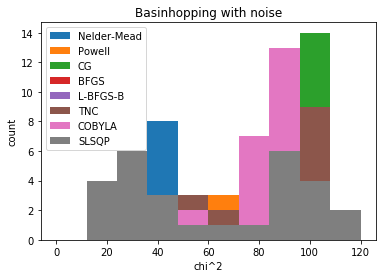

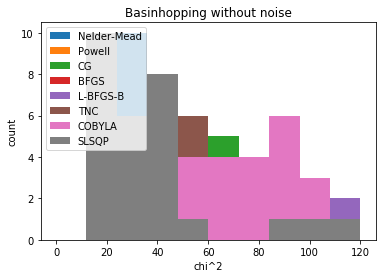

In [9]:
chi2_with_noise = {'Nelder-Mead':[],'Powell':[],'CG':[],'BFGS':[],'L-BFGS-B':[],'TNC':[],'COBYLA':[],'SLSQP':[]}
chi2_without_noise = {'Nelder-Mead':[],'Powell':[],'CG':[],'BFGS':[],'L-BFGS-B':[],'TNC':[],'COBYLA':[],'SLSQP':[]}
time_list = {'Nelder-Mead':[],'Powell':[],'CG':[],'BFGS':[],'L-BFGS-B':[],'TNC':[],'COBYLA':[],'SLSQP':[]}
methods = ['Nelder-Mead','Powell','CG','BFGS', 'L-BFGS-B','TNC','COBYLA','SLSQP']

for i in range(len(good_event)):
    evt_ID = good_event[i]
    dataset_name = '/clean'
    evt_full = full[dataset_name]
    xyzs_h5 = evt_full[str(evt_ID)]

    xyzs = np.array(xyzs_h5)

    #delete the points which are farther away from the center of the spiral
    del_list = []

    for i in range(len(xyzs)):
        if (xyzs[i,6]) > 150.0:
            del_list.append(i)
    cut_xyzs = np.delete(xyzs,del_list,axis=0)
    
    xy = xyzs[:, 0:2]
    xy_C = np.ascontiguousarray(xy, dtype=np.double)
    cx, cy = pytpc.cleaning.hough_circle(xy_C)

    cut_xy = cut_xyzs[:, 0:2]
    cut_xy_C = np.ascontiguousarray(cut_xy, dtype=np.double)
    cut_cx, cut_cy = pytpc.cleaning.hough_circle(cut_xy_C)
    
    uvw, (cu, cv) = mcfitter.preprocess(xyzs[:,0:5], center=(cx, cy), rotate_pads=False)
    uvw_values = uvw.values
    uvw_sorted = uvw.sort_values(by='w', ascending=True)
    prefit_data = uvw_sorted.iloc[-len(uvw_sorted) // 4:].copy()
    prefit_res = mcfitter.linear_prefit(prefit_data, cu, cv)
    ctr0 = mcfitter.guess_parameters(prefit_res)
    exp_pos = uvw_sorted[['u', 'v', 'w']].values.copy() / 1000
    exp_hits = np.zeros(10240)
    for a, p in uvw[['a', 'pad']].values:
        exp_hits[int(p)] = a
        
    cut_uvw, (cut_cu, cut_cv) = mcfitter.preprocess(cut_xyzs[:,0:5], center=(cut_cx, cut_cy), rotate_pads=False) # get calibrated set of data
    cut_uvw_values = cut_uvw.values
    cut_uvw_sorted = cut_uvw.sort_values(by='w', ascending=True)
    cut_prefit_data = cut_uvw_sorted.iloc[-len(cut_uvw_sorted) // 4:].copy()
    cut_prefit_res = mcfitter.linear_prefit(cut_prefit_data, cut_cu, cut_cv)
    cut_ctr0 = mcfitter.guess_parameters(cut_prefit_res)
    cut_exp_pos = cut_uvw_sorted[['u', 'v', 'w']].values.copy() / 1000
    cut_exp_hits = np.zeros(10240)
    for a, p in cut_uvw[['a', 'pad']].values:
        cut_exp_hits[int(p)] = a
        
    minimizer = Minimizer(mcfitter.tracker, mcfitter.evtgen, num_iters, num_pts, red_factor)
    
    def f(y):
        ctr = np.zeros([1,6])
        ctr[0] = y
        chi_result = minimizer.run_tracks(ctr, exp_pos, exp_hits)
        return sum(chi_result[0])
    eps = np.sqrt(np.finfo(np.float).eps)
    def jacobian(x):
        return scipy.optimize.approx_fprime(x,f,eps)
    
    def cut_f(y):
        ctr = np.zeros([1,6])
        ctr[0] = y
        chi_result = minimizer.run_tracks(ctr, cut_exp_pos, cut_exp_hits)
        return sum(chi_result[0])
    eps = np.sqrt(np.finfo(np.float).eps)
    def cut_jacobian(x):
        return scipy.optimize.approx_fprime(x,cut_f,eps)
    
    i = 1
    def callbackF(x, f, accept):
        global i
        print('{0:4d}{1: 3.6f}{2: 3.6f}{3: 3.6f}{4: 3.6f}{5: 3.6f}{6: 3.6f}{7: 3.6f}'.format(i,x[0],x[1],x[2],x[3],x[4],x[5],f))
        i += 1
        
    j = 1
    def cut_callbackF(x, f, accept):
        global j
        print('{0:4d}{1: 3.6f}{2: 3.6f}{3: 3.6f}{4: 3.6f}{5: 3.6f}{6: 3.6f}{7: 3.6f}'.format(j,x[0],x[1],x[2],x[3],x[4],x[5],f))
        j += 1
        
    for a in range(len(methods)):
        method = methods[a]
        t0 = time.time()
        results = scipy.optimize.basinhopping(f,ctr0, niter=10, T=0.01, stepsize=0.05, minimizer_kwargs={"method": method})
        t1 = time.time()
        time_list[method].append(t1-t0)
        if np.isnan(results.fun) != True:
            chi2_with_noise[method].append(results.fun)
        print('Basinhopping (with noise) event '+str(evt_ID)+' with '+str(method)+' method: '+str(t1-t0)+' seconds')
        print('chi2 value: '+str(results.fun))
        t3 = time.time()
        cut_results = scipy.optimize.basinhopping(cut_f,cut_ctr0, niter=10, T=0.01, stepsize=0.05, minimizer_kwargs={"method": method})
        t4 = time.time()
        time_list[method].append(t4-t3)
        if np.isnan(cut_results.fun) != True:
            chi2_without_noise[method].append(cut_results.fun)
        print('Basinhopping (without noise) event '+str(evt_ID)+' with '+str(method)+' method: '+str(t4-t3)+' seconds')
        print('chi2 value: '+str(cut_results.fun))
    
for a in range(len(methods)):
    method = methods[a]
    print("average time for "+method+": "+str(sum(time_list[method]) / float(len(time_list[method])))+" seconds")
    print('chi2 value (with noise) for '+method+": "+str(sum(chi2_with_noise[method]) / float(len(chi2_with_noise[method]))))
    print('chi2 value (without noise) for '+method+": "+str(sum(chi2_without_noise[method]) / float(len(chi2_without_noise[method]))))
              
for i in chi2_with_noise:
    plt.hist(chi2_with_noise[i], label=i, bins=10,range=(0,120))
    plt.title('Basinhopping with noise')
    plt.legend(loc=2)
    plt.xlabel('chi^2')
    plt.ylabel('count')
plt.show()


for i in chi2_without_noise:
    plt.hist(chi2_without_noise[i], label=i, bins=10,range=(0,120))
    plt.title('Basinhopping without noise')
    plt.legend(loc=2)
    plt.xlabel('chi^2')
    plt.ylabel('count')
plt.show()

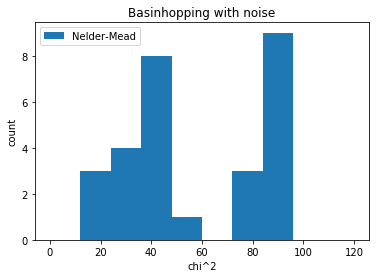

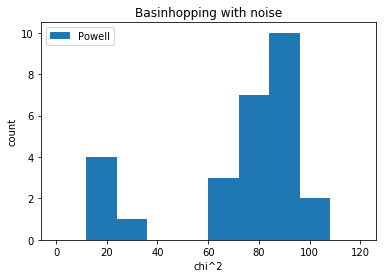

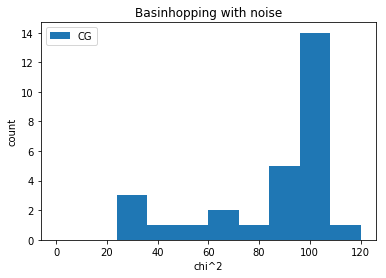

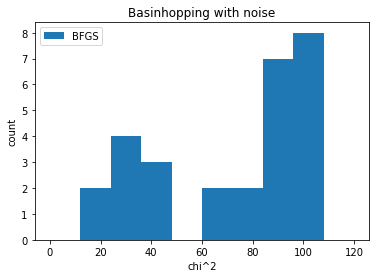

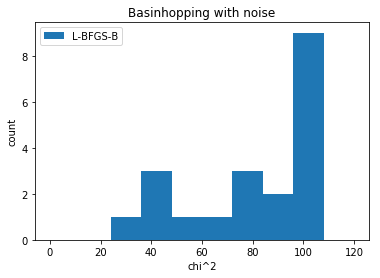

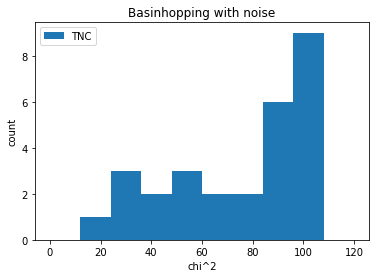

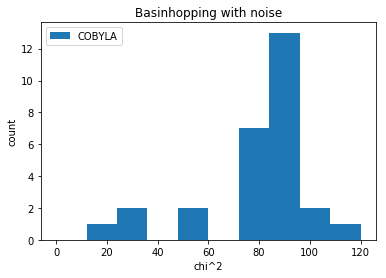

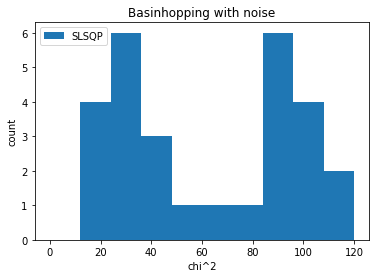

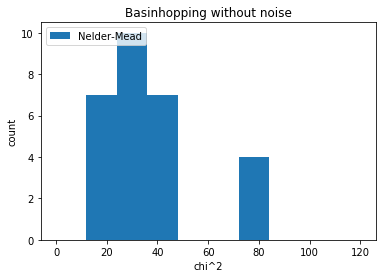

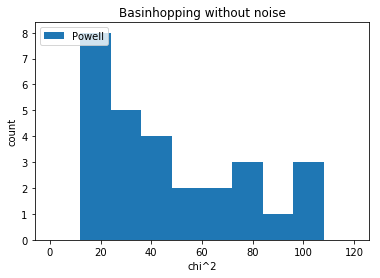

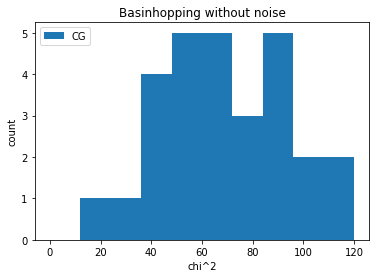

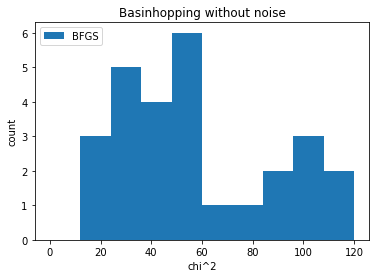

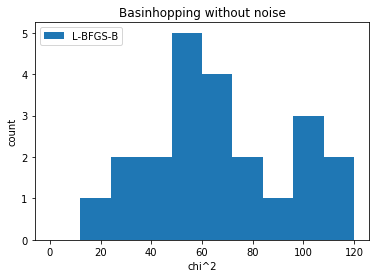

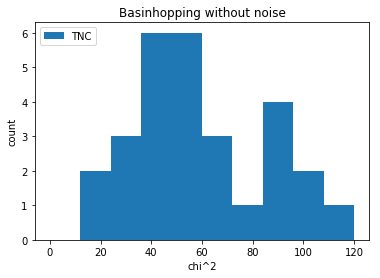

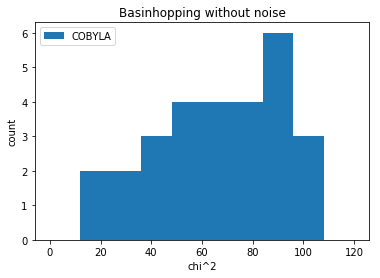

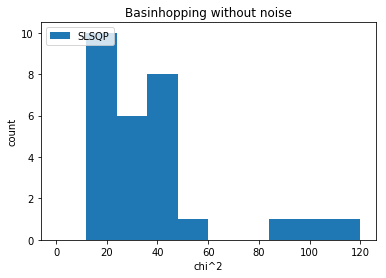

In [10]:
for i in chi2_with_noise:
    plt.hist(chi2_with_noise[i], label=i, bins=10,range=(0,120))
    plt.title('Basinhopping with noise')
    plt.legend(loc=2)
    plt.xlabel('chi^2')
    plt.ylabel('count')
    plt.show()


for i in chi2_without_noise:
    plt.hist(chi2_without_noise[i], label=i, bins=10,range=(0,120))
    plt.title('Basinhopping without noise')
    plt.legend(loc=2)
    plt.xlabel('chi^2')
    plt.ylabel('count')
    plt.show()